In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install tensorflow==2.9

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.7/511.7 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 36.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 27.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 37.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 24.7 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.5.0
    Uninstalling keras-3.5.0:
      Successfully uninstalled keras-3.5.0
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 24.3.25
    Uninstalling flatbuffers-24.3.25:
      Successfully uninstalled flatbuffers-24.3.25
  Attempting uninstall: tensorboard-data-server

In [ ]:
import os
import shutil
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import sklearn
import itertools
import random
from sklearn.metrics import classification_report
from keras.applications import *
from keras.layers import *
from keras.models import Model, load_model
from keras.optimizers import Adam
from sklearn.utils import class_weight
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.resnet_v2 import preprocess_input as base_preprocess
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, RocCurveDisplay, auc
from sklearn.utils.multiclass import unique_labels
from collections import Counter
from pathlib import Path
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight

In [ ]:
import os

data_path = '/content/drive/My Drive/Minor/celebV2'
for folder in os.listdir(data_path):
    print(folder, "contains:", os.listdir(os.path.join(data_path, folder))[:5])


Celeb-real contains: ['id0_0001.mp4', 'id0_0002.mp4', 'id0_0000.mp4', 'id0_0003.mp4', 'id0_0008.mp4']
Celeb-synthesis contains: ['id50_id55_0000.mp4', 'id50_id54_0009.mp4', 'id50_id54_0007.mp4', 'id50_id55_0007.mp4', 'id50_id56_0000.mp4']
YouTube-real contains: ['00002.mp4', '00004.mp4', '00012.mp4', '00010.mp4', '00008.mp4']


In [ ]:
import os

data_path = '/content/drive/My Drive/Minor/celebV2'
real_path = os.path.join(data_path, 'Celeb-real')
real_path1 = os.path.join(data_path, 'YouTube-real')
fake_path = os.path.join(data_path, 'Celeb-synthesis')

# List videos
real_videos = [os.path.join(real_path, f) for f in os.listdir(real_path) if f.endswith('.mp4')]
real_videos1 = [os.path.join(real_path1, f) for f in os.listdir(real_path1) if f.endswith('.mp4')]
fake_videos = [os.path.join(fake_path, f) for f in os.listdir(fake_path) if f.endswith('.mp4')]

print(f"Number of real videos: {len(real_videos)}")
print(f"Number of yt_real videos: {len(real_videos1)}")
print(f"Number of fake videos: {len(fake_videos)}")


Number of real videos: 590
Number of yt_real videos: 300
Number of fake videos: 5639


In [ ]:
import numpy as np
import cv2
import os

# Paths to video directories
real_path = '/content/drive/My Drive/Minor/celebV2/Celeb-real'
real_path1 = '/content/drive/My Drive/Minor/celebV2/YouTube-real'
fake_path = '/content/drive/My Drive/Minor/celebV2/Celeb-synthesis'

# List all video files in the directories
real_videos = [os.path.join(real_path, f) for f in os.listdir(real_path) if f.endswith('.mp4')]
real_videos1 = [os.path.join(real_path1, f) for f in os.listdir(real_path1) if f.endswith('.mp4')]
fake_videos = [os.path.join(fake_path, f) for f in os.listdir(fake_path) if f.endswith('.mp4')]

# Combine real video lists from both directories
all_real_videos = real_videos + real_videos1

# Limit the number of fake videos to 890
fake_videos = fake_videos[:890]

# Function to extract frames from videos
def load_video_frames(video_paths, frame_size=(224, 224), frames_per_video=3):
    frames = []
    for video_path in video_paths:
        try:
            cap = cv2.VideoCapture(video_path)
            count = 0
            while cap.isOpened() and count < frames_per_video:
                ret, frame = cap.read()
                if not ret:
                    break
                frame = cv2.resize(frame, frame_size)  # Resize frame to desired size
                frames.append(frame)
                count += 1
            cap.release()
        except Exception as e:
            print(f"Error processing video {video_path}: {e}")
    return np.array(frames)

# Load frames for real and fake videos
real_frames = load_video_frames(all_real_videos)  # Use all real videos
fake_frames = load_video_frames(fake_videos)  # Limit to 890 fake videos

# Concatenate frames
data = np.concatenate((real_frames, fake_frames), axis=0)

# Create labels (0 for real, 1 for fake)
real_labels = np.zeros(len(real_frames))
fake_labels = np.ones(len(fake_frames))

# Concatenate labels
labels = np.concatenate((real_labels, fake_labels), axis=0)

# Save data and labels as .npy files
np.save('/content/drive/My Drive/Minor/data_cv2.npy', data)
np.save('/content/drive/My Drive/Minor/label_cv2.npy', labels)

print(f"Data saved with {data.shape[0]} frames and {labels.shape[0]} labels.")


Data saved with 5338 frames and 5338 labels.


In [ ]:
data = np.load ('/content/drive/My Drive/Minor/data_cv2.npy',mmap_mode='r')
labels = np.load ('/content/drive/My Drive/Minor/label_cv2.npy',mmap_mode='r')

In [ ]:
print("Data shape:", data.shape)
print("Labels shape:", labels.shape)


Data shape: (5338, 224, 224, 3)
Labels shape: (5338,)


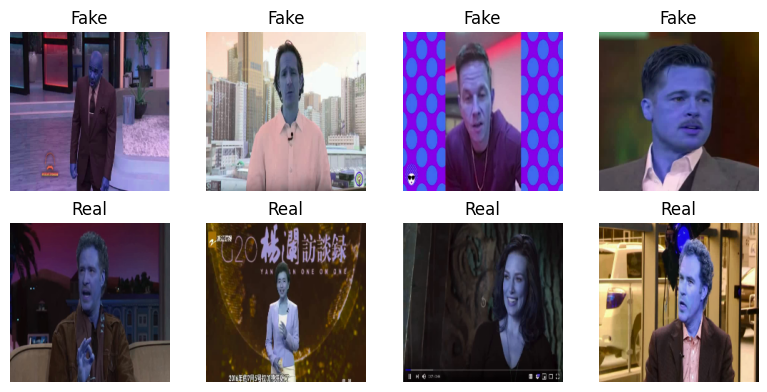

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Get unique class labels in the labels array (e.g., 0 for Fake, 1 for Real)
unique_classes = np.unique(labels)

# Create a dictionary to store four random data samples from each class
class_samples = {}

# Map class indices to their corresponding names
class_names = {0: "Fake", 1: "Real"}

# Select four random data samples from each class
for class_label in unique_classes:
    class_indices = np.where(labels == class_label)[0]  # Get indices for each class
    random_indices = np.random.choice(class_indices, 4, replace=False)  # Randomly select 4 indices
    class_samples[class_label] = [data[index] for index in random_indices]

# Plot the randomly selected images in 2 rows and 4 columns
plt.figure(figsize=(8, 4))  # Adjust figure size as needed
for i, (class_label, image_data_list) in enumerate(class_samples.items()):
    class_name = class_names[class_label]  # Get the corresponding class name
    for j, image_data in enumerate(image_data_list):
        plt.subplot(2, 4, i * 4 + j + 1)
        plt.imshow(image_data)
        plt.title(f'{class_name}')
        plt.axis('off')

plt.tight_layout()
plt.show()


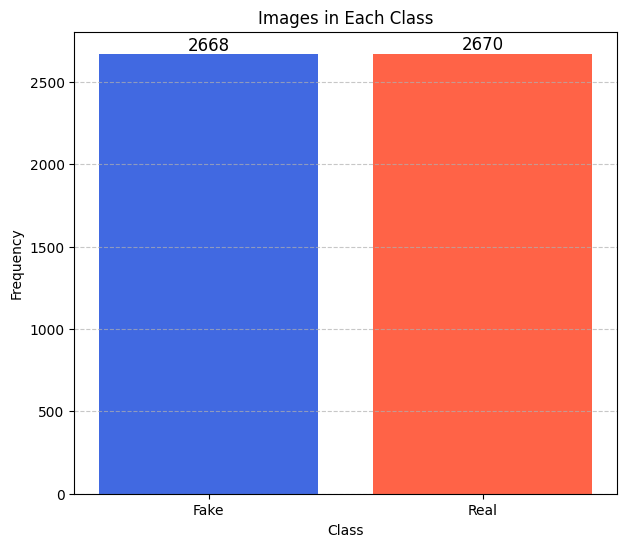

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming labels is a 1D array of class indices (e.g., [0, 1, 1, 0, ...]) or one-hot encoded
if len(labels.shape) == 1:
    # If labels are flat, count occurrences of each class
    class_counts = np.bincount(labels.astype(int))
else:
    # If labels are one-hot encoded, sum along the rows
    class_counts = np.sum(labels, axis=0)

# Map class indices to their corresponding names
class_names = {0: "Fake", 1: "Real"}

# Define custom colors for each class
colors = ['royalblue', 'tomato']

# Plot the class frequencies with custom colors
plt.figure(figsize=(7, 6))
bars = plt.bar(
    [class_names[class_idx] for class_idx in range(len(class_counts))],
    class_counts,
    color=colors
)
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Images in Each Class')

# Annotate the bars with the class frequencies (integer format)
for bar, count in zip(bars, class_counts):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        count,
        str(int(count)),
        ha='center',
        va='bottom',
        fontsize=12
    )

plt.grid(axis='y', linestyle='--', alpha=0.7)  # Optional: Add grid for better readability
plt.show()


In [ ]:
# Split the data into train, test, and validation sets
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.1, stratify = labels, random_state = 42)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size=0.1, stratify = train_labels, random_state = 42)

In [ ]:
print("train_data shape:", train_data.shape)
print("train_labels shape:", train_labels.shape)
print("val_data shape:", val_data.shape)
print("val_labels shape:", val_labels.shape)
print("test_data shape:", test_data.shape)
print("test_labels shape:", test_labels.shape)

train_data shape: (4323, 224, 224, 3)
train_labels shape: (4323,)
val_data shape: (481, 224, 224, 3)
val_labels shape: (481,)
test_data shape: (534, 224, 224, 3)
test_labels shape: (534,)


In [ ]:
print(train_labels.shape)  # Check the shape of train_labels
print(val_labels.shape)    # Check the shape of val_labels
print(test_labels.shape)   # Check the shape of test_labels


(4323, 2)
(481, 2)
(534, 2)


In [ ]:
from keras.utils import to_categorical

# If labels are integer-encoded, you can convert them to one-hot encoding
train_labels = to_categorical(train_labels, num_classes=2)
val_labels = to_categorical(val_labels, num_classes=2)
test_labels = to_categorical(test_labels, num_classes=2)

print(train_labels.shape)  # Should print (num_samples, 2)


(4323, 2)


In [ ]:
class_names_mapping = { 0: "Fake", 1: "Real" }
# Calculate class distribution in each set
num_classes = train_labels.shape[1]
class_counts_train = np.sum(train_labels, axis=0)
class_counts_val = np.sum(val_labels, axis=0)
class_counts_test = np.sum(test_labels, axis=0)

class_counts_mapping = {}
for index, class_name in class_names_mapping.items():
    class_counts_mapping[class_name] = {'Train': class_counts_train[index]}

for index, class_name in class_names_mapping.items():
    class_counts_mapping[class_name]['Validation'] = class_counts_val[index]

for index, class_name in class_names_mapping.items():
    class_counts_mapping[class_name]['Test'] = class_counts_test[index]

# Print class distribution mapping
for class_name, counts in class_counts_mapping.items():
    print(class_name)
    for set_name, count in counts.items():
        print(f" - {set_name}: {count}")

Fake
 - Train: 2161.0
 - Validation: 240.0
 - Test: 267.0
Real
 - Train: 2162.0
 - Validation: 241.0
 - Test: 267.0


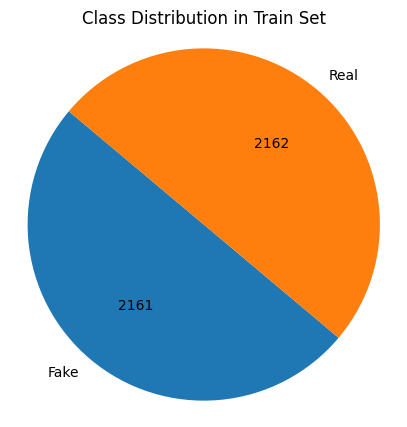

In [ ]:
# Create pie charts for each set
for set_name in ['Train']:
    class_counts = [counts[set_name] for counts in class_counts_mapping.values()]
    class_labels = list(class_counts_mapping.keys())

    plt.figure(figsize=(5, 5))
    plt.pie(class_counts, labels=class_labels, startangle=140, autopct=lambda p: '{:.0f}'.format(p * sum(class_counts) / 100))
    plt.title(f'Class Distribution in {set_name} Set')
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.show()

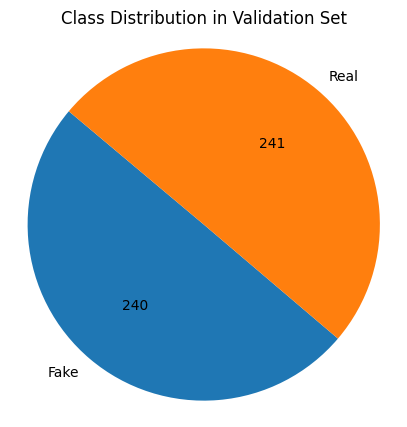

In [ ]:
# Create pie charts for each set
for set_name in ['Validation']:
    class_counts = [counts[set_name] for counts in class_counts_mapping.values()]
    class_labels = list(class_counts_mapping.keys())

    plt.figure(figsize=(5, 5))
    plt.pie(class_counts, labels=class_labels, startangle=140, autopct=lambda p: '{:.0f}'.format(p * sum(class_counts) / 100))
    plt.title(f'Class Distribution in {set_name} Set')
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.show()


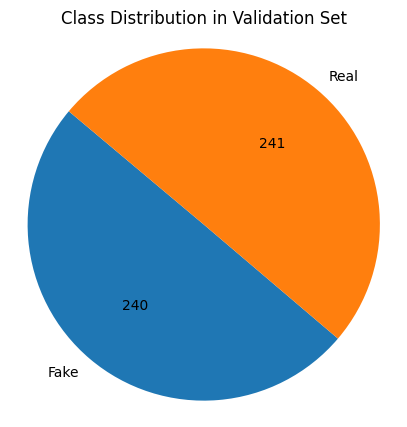

In [ ]:
# Create pie charts for each set
for set_name in ['Validation']:
    class_counts = [counts[set_name] for counts in class_counts_mapping.values()]
    class_labels = list(class_counts_mapping.keys())

    plt.figure(figsize=(5, 5))
    plt.pie(class_counts, labels=class_labels, startangle=140, autopct=lambda p: '{:.0f}'.format(p * sum(class_counts) / 100))
    plt.title(f'Class Distribution in {set_name} Set')
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.show()


In [ ]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder

# Assuming train_labels is one-hot encoded, convert to class labels
train_labels_encoded = np.argmax(train_labels, axis=1)

# Initialize the label encoder (optional step, but if you need actual labels instead of 0/1)
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels_encoded)

# Calculate class weights based on the labels
class_weights = compute_class_weight('balanced', classes=np.unique(train_labels_encoded), y=train_labels_encoded)

# Create a dictionary of class weights
class_weight_dict = dict(enumerate(class_weights))

# Print the class weight dictionary
print("Class weight dictionary:", class_weight_dict)


Class weight dictionary: {0: 1.0002313743637206, 1: 0.9997687326549491}


In [ ]:
lr_reduce = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.5, patience = 5,mode='max', min_lr = 1e-4,verbose = 1)
#early_stop = EarlyStopping(monitor = "val_loss", patience = 5, verbose=1)
saved_model = ('/content/drive/MyDrive/Minor/InceptionResNet_celeb.h5')
model_chkpt = ModelCheckpoint(saved_model ,save_best_only = True, monitor = 'val_accuracy',verbose = 1)

# callback_list = [early_stop, model_chkpt, lr_reduce]
callback_list = [model_chkpt, lr_reduce]

In [ ]:
base_model = InceptionResNetV2(weights='imagenet',
                      include_top=False,
                      input_shape=(224, 224, 3))

In [ ]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(2, activation='softmax')(x)

# Create the final model with custom classification layers
model = Model(inputs=base_model.input, outputs=predictions)


# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
from keras.models import load_model
model = load_model('/content/drive/MyDrive/Minor/InceptionResNet_celeb.h5')

In [ ]:
epochs = 10
batch_size = 16

In [ ]:
#last_saved_epoch = 9
history = model.fit(train_data, train_labels, batch_size=batch_size,
                    validation_data=(val_data, val_labels),
                    epochs=epochs,
                    callbacks=callback_list,
                    class_weight = class_weight_dict)
                    #initial_epoch = last_saved_epoch)

Epoch 1/10
271/271 [==============================] - ETA: 0s - loss: 0.5679 - accuracy: 0.7393 
Epoch 1: val_accuracy improved from -inf to 0.64241, saving model to /content/drive/MyDrive/Minor/InceptionResNet_celeb.h5
271/271 [==============================] - 5442s 20s/step - loss: 0.5679 - accuracy: 0.7393 - val_loss: 0.6166 - val_accuracy: 0.6424 - lr: 0.0010
Epoch 2/10
271/271 [==============================] - ETA: 0s - loss: 0.4315 - accuracy: 0.8450 
Epoch 2: val_accuracy improved from 0.64241 to 0.83160, saving model to /content/drive/MyDrive/Minor/InceptionResNet_celeb.h5
271/271 [==============================] - 5399s 20s/step - loss: 0.4315 - accuracy: 0.8450 - val_loss: 0.4655 - val_accuracy: 0.8316 - lr: 0.0010
Epoch 3/10
271/271 [==============================] - ETA: 0s - loss: 0.3557 - accuracy: 0.8781 
Epoch 3: val_accuracy did not improve from 0.83160
271/271 [==============================] - 5347s 20s/step - loss: 0.3557 - accuracy: 0.8781 - val_loss: 0.5141 - va

In [ ]:
epochs = 5
batch_size = 16

In [ ]:
last_saved_epoch = 3
history = model.fit(train_data, train_labels, batch_size=batch_size,
                    validation_data=(val_data, val_labels),
                    epochs=epochs,
                    callbacks=callback_list,
                    class_weight = class_weight_dict,
                    initial_epoch = last_saved_epoch)

Epoch 4/5
271/271 [==============================] - ETA: 0s - loss: 0.3751 - accuracy: 0.8723 
Epoch 4: val_accuracy improved from -inf to 0.86694, saving model to /content/drive/MyDrive/Minor/InceptionResNet_celeb.h5
271/271 [==============================] - 5271s 19s/step - loss: 0.3751 - accuracy: 0.8723 - val_loss: 0.2914 - val_accuracy: 0.8669 - lr: 0.0010
Epoch 5/5
271/271 [==============================] - ETA: 0s - loss: 0.3178 - accuracy: 0.8906 
Epoch 5: val_accuracy improved from 0.86694 to 0.92516, saving model to /content/drive/MyDrive/Minor/InceptionResNet_celeb.h5
271/271 [==============================] - 5209s 19s/step - loss: 0.3178 - accuracy: 0.8906 - val_loss: 0.2196 - val_accuracy: 0.9252 - lr: 0.0010


In [ ]:
print(history.history)


{'loss': [0.37506911158561707, 0.31778788566589355], 'accuracy': [0.8723108768463135, 0.8905852437019348], 'val_loss': [0.29141974449157715, 0.21959324181079865], 'val_accuracy': [0.866943895816803, 0.9251559376716614], 'lr': [0.001, 0.001]}


In [ ]:
test_loss, test_accuracy = model.evaluate(test_data, test_labels)
print("Test Accuracy:", test_accuracy)

17/17 [==============================] - 148s 8s/step - loss: 0.2664 - accuracy: 0.9139
Test Accuracy: 0.9138576984405518


In [ ]:
# Make predictions on the test data
predictions = model.predict(test_data)

# Convert predictions and true labels to integer format
predicted_labels = np.argmax(predictions, axis=1)
# test_labels = test_data.classes
true_labels = np.argmax(test_labels, axis=1)

# Calculate the classification report
report = classification_report(true_labels, predicted_labels)

# Print the classification report
print("Classification Report:")
print(report)

17/17 [==============================] - 167s 9s/step
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.84      0.91       267
           1       0.86      0.99      0.92       267

    accuracy                           0.91       534
   macro avg       0.92      0.91      0.91       534
weighted avg       0.92      0.91      0.91       534



In [ ]:
# Calculate the confusion matrix
cm = confusion_matrix(true_labels, np.round(predicted_labels))

cm

array([[223,  44],
       [  2, 265]])

Confusion matrix, without normalization


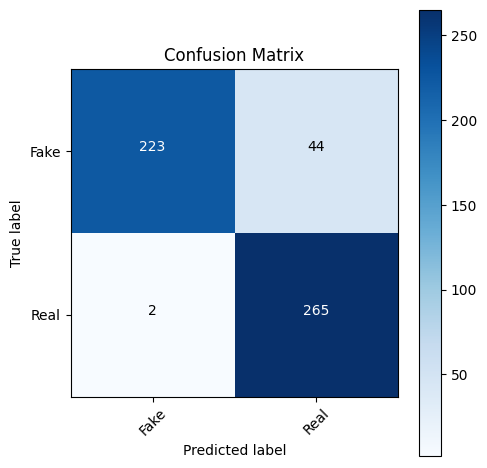

In [ ]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    print('Confusion matrix, without normalization')

    plt.figure(figsize=(5, 5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'  # Remove '.2f' format for non-normalized values
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cm_plot_labels = ["Fake", "Real"]

plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')
plt.show()


In [ ]:
!pip install tf-keras-vis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 2.3 MB/s eta 0:00:00


In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from tensorflow.python.client import device_lib
device_list = device_lib.list_local_devices()
gpus = [device.name for device in device_list if device.device_type == 'GPU']
print('TensorFlow recognized {} GPUs'.format(len(gpus)))

TensorFlow recognized 0 GPUs


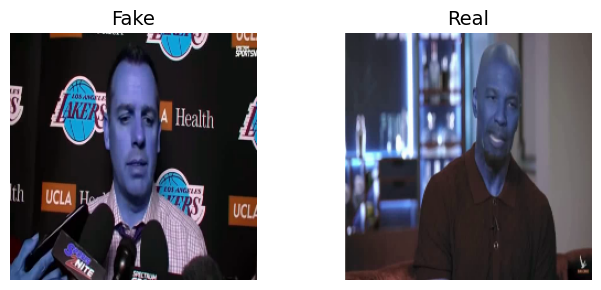

In [ ]:
binary_labels = ["Fake", "Real"]

# Convert one-hot encoded labels to integer labels
test_labels_int = np.argmax(test_labels, axis=1)

# Create an array to store the images
image_array = []

# Create subplots for 2 images in a single row (1 real and 1 fake)
num_images = 2
fig, ax = plt.subplots(1, num_images, figsize=(7, 3))

for i in range(2):  # Loop through binary classes: "Real" and "Fake"
    # Find indices of images for the current class
    class_indices = np.where(test_labels_int == i)[0]
    random_index = np.random.choice(class_indices, 1, replace=False)  # Choose 1 random index

    # Display the image from test data
    img = test_data[random_index[0]]
    image_array.append(img)  # Store the image in the array

    ax[i].imshow(img)
    ax[i].set_title(binary_labels[i], fontsize=14)
    ax[i].axis('off')

plt.tight_layout()
plt.show()

# Now you can preprocess the image_array as needed with base_preprocess function
X = base_preprocess(np.array(image_array))

In [ ]:
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear

replace2linear = ReplaceToLinear()

# Instead of using the ReplaceToLinear instance above,
# you can also define the function from scratch as follows:
def model_modifier_function(cloned_model):
    cloned_model.layers[-1].activation = tf.keras.activations.linear


In [ ]:
from tf_keras_vis.utils.scores import CategoricalScore

# 1 is the imagenet index corresponding to Goldfish, 294 to Bear and 413 to Assault Rifle.
score = CategoricalScore([0, 1])

# Instead of using CategoricalScore object,
# you can also define the function from scratch as follows:
def score_function(output):
    # The `output` variable refers to the output of the model,
    # so, in this case, `output` shape is `(3, 1000)` i.e., (samples, classes).
    return (output[0][1])

SMOOTH GRAD

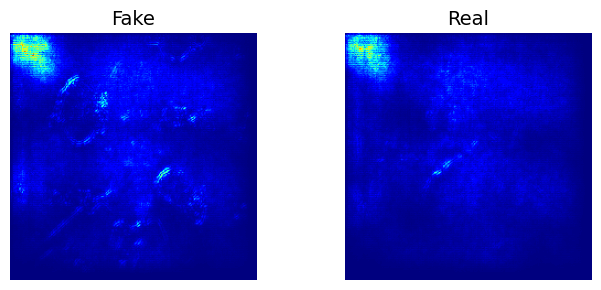

CPU times: user 1min 42s, sys: 2.99 s, total: 1min 45s
Wall time: 1min 45s


In [ ]:
%%time
from tensorflow.keras import backend as K
from tf_keras_vis.saliency import Saliency

# Create Saliency object.
saliency = Saliency(model, model_modifier=replace2linear, clone=True)

# Generate saliency maps with smoothing that reduces noise by adding noise
saliency_maps = saliency(score,
                         X,
                         smooth_samples=20,
                         smooth_noise=0.20)

# Calculate the number of images
num_images = len(binary_labels)

# Create a single row plot
# fig, axes = plt.subplots(1, num_images, figsize=(7, 3))
f, axes = plt.subplots(nrows=1, ncols=2, figsize=(7, 3))
for i, title in enumerate(binary_labels):
    axes[i].set_title(title, fontsize=14)
    axes[i].imshow(saliency_maps[i], cmap='jet')
    axes[i].axis('off')

plt.tight_layout()
plt.show()


GRADCAM

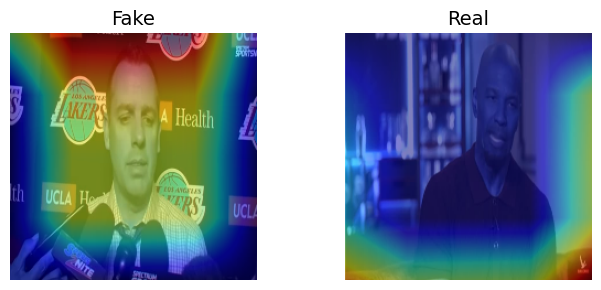

CPU times: user 12.4 s, sys: 410 ms, total: 12.8 s
Wall time: 10.7 s


In [ ]:
%%time

from matplotlib import cm
from tf_keras_vis.gradcam import Gradcam

# Create Gradcam object
gradcam = Gradcam(model,
                  model_modifier=replace2linear,
                  clone=True)

# Generate heatmap with GradCAM
cam = gradcam(score,
              X,
              penultimate_layer=-1)

## Since v0.6.0, calling `normalize()` is NOT necessary.
# cam = normalize(cam)

# Render
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(7, 3))
for i, title in enumerate(binary_labels):
    heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
    ax[i].set_title(title, fontsize=14)
    ax[i].imshow(image_array[i])
    ax[i].imshow(heatmap, cmap='jet', alpha=0.5) # overlay
    ax[i].axis('off')
plt.tight_layout()
plt.show()


GRADCAM++

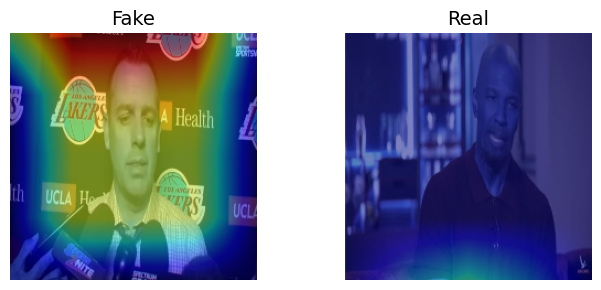

CPU times: user 12.7 s, sys: 488 ms, total: 13.2 s
Wall time: 11 s


In [ ]:
%%time

from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus

# Create GradCAM++ object
gradcam = GradcamPlusPlus(model,
                          model_modifier=replace2linear,
                          clone=True)

# Generate heatmap with GradCAM++
cam = gradcam(score,
              X,
              penultimate_layer=-1)

## Since v0.6.0, calling `normalize()` is NOT necessary.
# cam = normalize(cam)

# Render
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(7, 3))
for i, title in enumerate(binary_labels):
    heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
    ax[i].set_title(title, fontsize=14)
    ax[i].imshow(image_array[i])
    ax[i].imshow(heatmap, cmap='jet', alpha=0.5)
    ax[i].axis('off')
plt.tight_layout()
plt.show()

FASTER SCORECAM

1/1 [==============================] - 9s 9s/step


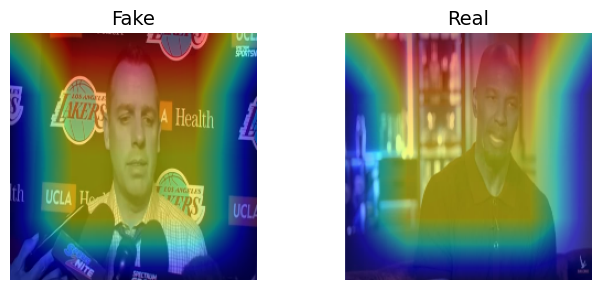

CPU times: user 21.3 s, sys: 513 ms, total: 21.8 s
Wall time: 17.5 s


In [ ]:
%%time

from tf_keras_vis.scorecam import Scorecam

# Create ScoreCAM object
scorecam = Scorecam(model, model_modifier=replace2linear)

# Generate heatmap with Faster-ScoreCAM
cam = scorecam(score,
               X,
               penultimate_layer=-1,
               max_N=10)

## Since v0.6.0, calling `normalize()` is NOT necessary.
# cam = normalize(cam)

# Render
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(7, 3))
for i, title in enumerate(binary_labels):
    heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
    ax[i].set_title(title, fontsize=14)
    ax[i].imshow(image_array[i])
    ax[i].imshow(heatmap, cmap='jet', alpha=0.5)
    ax[i].axis('off')
plt.tight_layout()
plt.show()
